In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
sns.set()

In [2]:
dir_pth = {}
dir_pth['result'] = '/home/rohan/Remote-AI/dat/result/TE_Patchseq_Bioarxiv/'
dir_pth['logs'] = dir_pth['result']+'logs/'
dir_pth['checkpoints'] =dir_pth['result']+'checkpoints/'

In [3]:
%matplotlib inline

**Hyperparameter search results**: 
 - 9-fold cross validated mse reconstruction and coupling losses 
 - For `v2`: `1500` epochs for regular training followed by `500` steps of fine tuning

In [4]:
this_epoch=499
csTE_array = np.array([0.0,0.1,1.0,2.0,5.0])
aE_array = np.array([0.1,0.2,0.5,1.0,1.5,2.0])

T_recon_mean = np.empty((csTE_array.size,aE_array.size))
E_recon_mean = np.empty((csTE_array.size,aE_array.size))
M_recon_mean = np.empty((csTE_array.size,aE_array.size))
TE_dist_mean = np.empty((csTE_array.size,aE_array.size))

for i,csTE in enumerate(csTE_array):
    csTE = str(csTE).replace('.','-')
    for j,aE in enumerate(aE_array):
        aE = str(aE).replace('.','-')
        temp_T=[]
        temp_E=[]
        temp_M=[]
        temp_TE=[]
        for cv in range(9):
            file_id = 'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft.csv'
            D = pd.read_csv(dir_pth['logs']+file_id)
            epoch_ind=D['train_epoch'].values==this_epoch
            temp_T.extend(D['val_mse_T'].values[epoch_ind])
            temp_E.extend(D['val_mse_E'].values[epoch_ind])
            temp_M.extend(D['val_mse_M'].values[epoch_ind])
            temp_TE.extend(D['val_mse_TE'].values[epoch_ind])
        T_recon_mean[i,j]=np.mean(temp_T)
        E_recon_mean[i,j]=np.mean(temp_E)
        M_recon_mean[i,j]=np.mean(temp_M)
        TE_dist_mean[i,j]=np.mean(temp_TE)

In [5]:
def plot_heatmap(ax,M,Xarr,Yarr,Xlabel=r'$\lambda_{te}$',Ylabel=r'$\alpha_{e}$',title='T recon',c=(0,1)):
    im = ax.imshow(M.T,vmin = c[0],vmax=c[1])
    ax.set_xticks(np.arange(len(Xarr)))
    ax.set_yticks(np.arange(len(Yarr)))
    ax.set_xticklabels(Xarr)
    ax.set_yticklabels(Yarr)
    ax.set_xlabel(r'$\lambda_{te}$')
    ax.set_ylabel(Ylabel)
    for i in range(Xarr.size):
        for j in range(Yarr.size):
            text = ax.text(i, j, '{:0.3f}'.format(M[i, j]),
                           ha="center", va="center", color="w")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.grid(False)
    ax.set_title(title)
    
    return

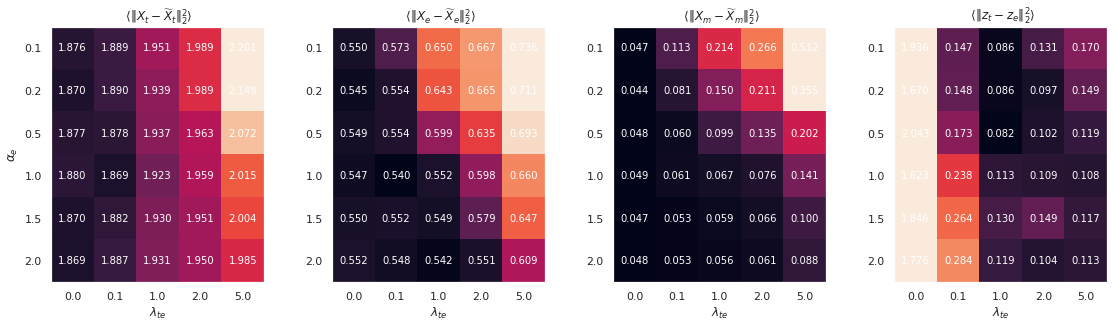

In [6]:
fig, ax = plt.subplots(1,4,figsize=(16,4.5))
plot_heatmap(ax=ax[0],M=T_recon_mean,Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{te}$',Ylabel=r'$\alpha_{e}$',title=r' $ \langle \Vert X_{t} -  \widetilde{X}_{t} \Vert_2^2 \rangle $',c=(1.85,2.10))
plot_heatmap(ax=ax[1],M=E_recon_mean,Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{te}$',Ylabel='',title=r' $ \langle \Vert X_{e} -  \widetilde{X}_{e} \Vert_2^2 \rangle $',c=(0.54,0.7))
plot_heatmap(ax=ax[2],M=M_recon_mean,Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{te}$',Ylabel='',title=r' $ \langle \Vert X_{m} -  \widetilde{X}_{m} \Vert_2^2 \rangle $',c=(0.05,0.35))
plot_heatmap(ax=ax[3],M=TE_dist_mean,Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{te}$',Ylabel='',title=r' $ \langle \Vert z_{t} -  z_{e} \Vert_2^2 \rangle $',c=(0.08,0.35))
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Hyperparameter_search_1500_ep_v2_ft.png',dpi=300)

**Individual training curves**: Checks to determine if over-fitting is problematic.

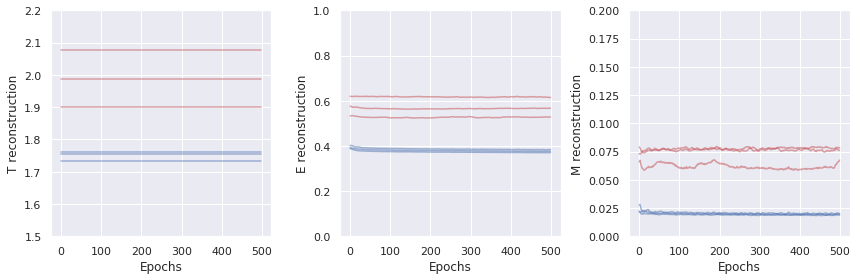

In [7]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
for cv in range(3):
    D = pd.read_csv(dir_pth['logs']+'v2_aT_1-0_aE_1-0_aM_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft.csv')
    plt.sca(ax[0])
    plt.plot(D['train_epoch'],D['train_mse_T'],'-b',alpha=0.5)
    plt.plot(D['val_epoch'],D['val_mse_T'],'-r',alpha=0.5)
    ax[0].set_ylabel('T reconstruction')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylim(1.5,2.2)
    
    plt.sca(ax[1])
    plt.plot(D['train_epoch'],D['train_mse_E'],'-b',alpha=0.5)
    plt.plot(D['val_epoch'],D['val_mse_E'],'-r',alpha=0.5)
    ax[1].set_ylabel('E reconstruction')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylim(0,1)
    
    plt.sca(ax[2])
    plt.plot(D['train_epoch'],D['train_mse_M'],'-b',alpha=0.5)
    plt.plot(D['val_epoch'],D['val_mse_M'],'-r',alpha=0.5)
    ax[2].set_ylabel('M reconstruction')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylim(0,0.2)
plt.tight_layout()

**Per feature reconstruction error**

In [8]:
raw_data_pth = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'

#E feature names (confirm with Nathan)
E_features_list = pd.read_csv(raw_data_pth+'sparse_pca_components_mMET_curated_Nov11_withheaders.csv')
E_features_list = E_features_list.columns[1:].values
ME_features_list = E_features_list.tolist()
ME_features_list.append('soma depth')

for i,e in enumerate(ME_features_list):
    e=e.replace('spiking','spike')
    e=e.replace('upstroke','up')
    e=e.replace('downstroke','down')
    e=e.replace('_',' ')
    print(e)
    ME_features_list[i]=e

E_features_list = ME_features_list[:-1]
E_features_arr = np.array(E_features_list)
#Full data matrices
O = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)

first ap v 0
first ap v 1
first ap v 2
first ap v 3
first ap v 4
first ap dv 0
first ap dv 1
first ap dv 2
first ap dv 3
first ap dv 4
first ap dv 5
isi shape 0
isi shape 1
isi shape 2
step subthresh 0
step subthresh 1
subthresh norm 0
subthresh norm 1
subthresh norm 2
subthresh norm 3
inst freq 0
inst freq 1
inst freq 2
inst freq 3
inst freq 4
inst freq 5
spike up down ratio 0
spike up down ratio 1
spike peak v 0
spike peak v 1
spike fast trough v 0
spike fast trough v 1
spike threshold v 0
spike threshold v 1
spike threshold v 2
spike width 0
spike width 1
inst freq norm 0
inst freq norm 1
inst freq norm 2
inst freq norm 3
inst freq norm 4
inst freq norm 5
inst freq norm 6
soma depth


In [9]:
csTE = '1-0'
aE = '1-0'

X = np.empty(shape=(9,E_features_arr.size))
Y = np.empty(shape=(9,E_features_arr.size))
for cv in range(9):
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    Y[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE_from_XT'][D['val_ind'],:-1]),axis=0)    

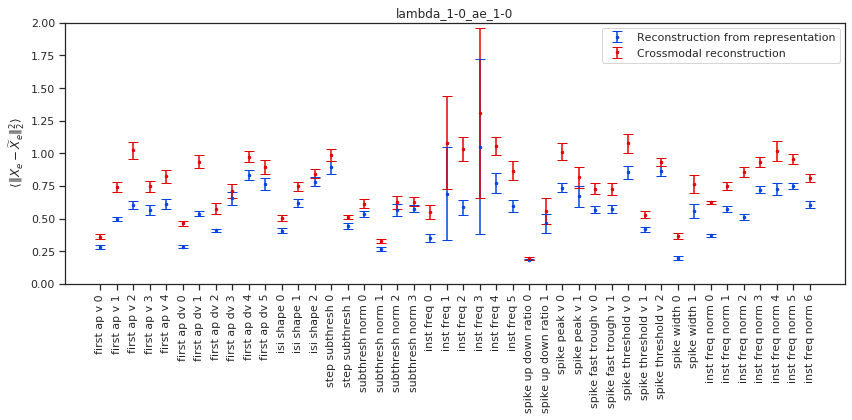

In [10]:
sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
cols = ['#0343df','#e50000']

xx = np.arange(0,X.shape[1],1)

#With modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

#Cross modal prediction
yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)/np.sqrt(Y.shape[0])

fig = plt.figure(figsize=(12,6))
plt.errorbar(x=xx,y=yy,yerr=err,c=cols[0],capsize=5,ls='',marker='.',ms=5,label='Reconstruction from representation')
plt.errorbar(x=xx,y=yy2,yerr=err2,c=cols[1],capsize=5,ls='',marker='.',ms=5,label='Crossmodal reconstruction')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_list)))
ax.set_xticklabels(E_features_list,rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} - \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.0)
plt.legend()
plt.title('lambda_'+str(csTE)+'_ae_'+str(aE))
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_lambda_'+str(csTE)+'_ae_'+str(aE)+'_v2_ft.png',dpi=300)

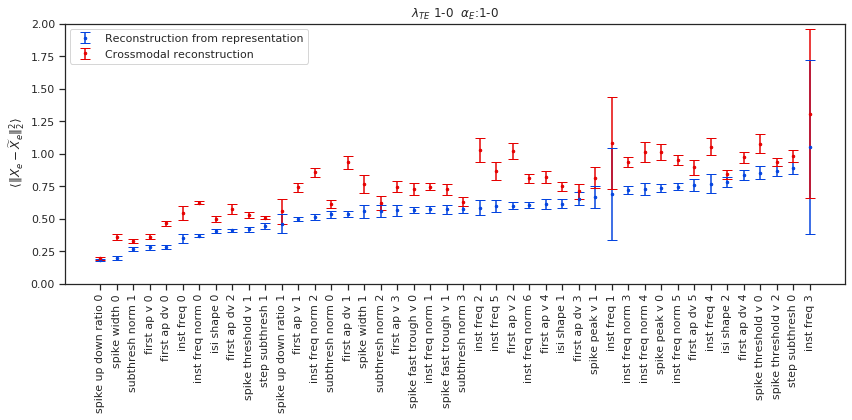

In [11]:
ind=np.argsort(yy)
fig = plt.figure(figsize=(12,6))
plt.errorbar(x=xx,y=yy[ind],yerr=err[ind],c=cols[0],capsize=5,ls='',marker='.',ms=5,label='Reconstruction from representation')
plt.errorbar(x=xx,y=yy2[ind],yerr=err2[ind],c=cols[1],capsize=5,ls='',marker='.',ms=5,label='Crossmodal reconstruction')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_arr)))
ax.set_xticklabels(E_features_arr[ind],rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} - \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.0)
plt.legend()
plt.title(r'$\lambda_{TE}$ '+str(csTE)+'  '+r'$\alpha_{E}$:'+str(aE))
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epredsorted_lambda_'+str(csTE)+'_ae_'+str(aE)+'_v2_ft.png',dpi=300)

In [12]:
dir_pth = {}
dir_pth['result'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
dir_pth['logs'] = dir_pth['result']+'logs/'
dir_pth['checkpoints'] =dir_pth['result']+'checkpoints/'

aE = '1-0'

X = np.empty(shape=(9,E_features_arr.size))
Y = np.empty(shape=(9,E_features_arr.size))
Z = np.empty(shape=(9,E_features_arr.size))
for cv in range(9):
    csTE = '1-0'    
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    csTE = '0-1'
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Y[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    csTE = '0-0'
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Z[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)

In [36]:
cols = sns.color_palette("coolwarm", 3)

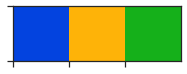

In [44]:

cols = sns.xkcd_palette(["blue", "amber", "green"])
sns.palplot(cols)
#sns.palplot(sns.color_palette(cols))

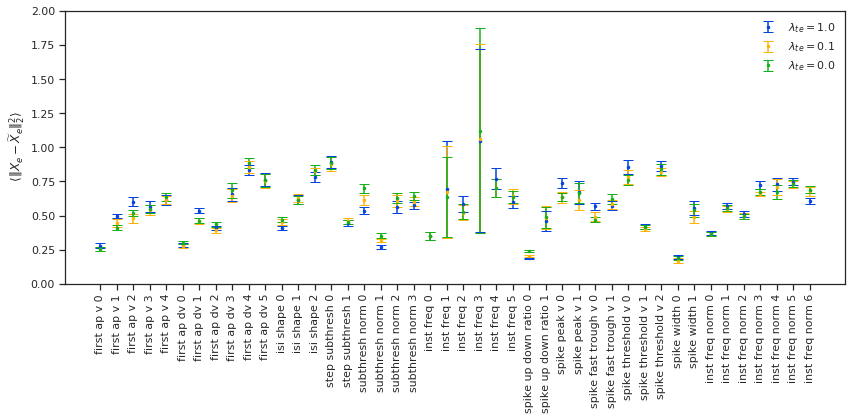

In [45]:
xx = np.arange(0,X.shape[1],1)

#Within modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)/np.sqrt(Y.shape[0])

yy3=np.mean(Z,axis=0)
err3=np.std(Z,axis=0)/np.sqrt(Z.shape[0])

fig = plt.figure(figsize=(12,6))
sns.set()
sns.set_style('ticks',{'axes.grid' : False})

plt.errorbar(x=xx,y=yy,yerr=err,capsize=5,c=cols[0],ls='',marker='.',ms=5,label=r'$\lambda_{te}=1.0$')
plt.errorbar(x=xx,y=yy2,yerr=err2,capsize=5,c=cols[1],ls='',marker='.',ms=5,label=r'$\lambda_{te}=0.1$')
plt.errorbar(x=xx,y=yy3,yerr=err3,capsize=5,c=cols[2],ls='',marker='.',ms=5,label=r'$\lambda_{te}=0.0$')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_list)))
ax.set_xticklabels(E_features_list,rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} -  \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.0)
plt.legend(edgecolor='None')
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_lambda_sweep_v2_ft.png',dpi=300)

**Effect of latent space dimensionality on electrophysiological reconstruction**

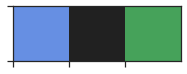

In [61]:

cols = sns.diverging_palette(255, 133, l=60, n=3, center="dark")
sns.palplot(cols)

In [62]:
dir_pth = {}
dir_pth['result'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
dir_pth['logs'] = dir_pth['result']+'logs/'
dir_pth['checkpoints'] =dir_pth['result']+'checkpoints/'

aE = '1-0'
csTE = '1-0'

X = np.empty(shape=(9,E_features_arr.size))
Y = np.empty(shape=(9,E_features_arr.size))
Z = np.empty(shape=(9,E_features_arr.size))
for cv in range(9):
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_2_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Y[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_5_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Z[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)

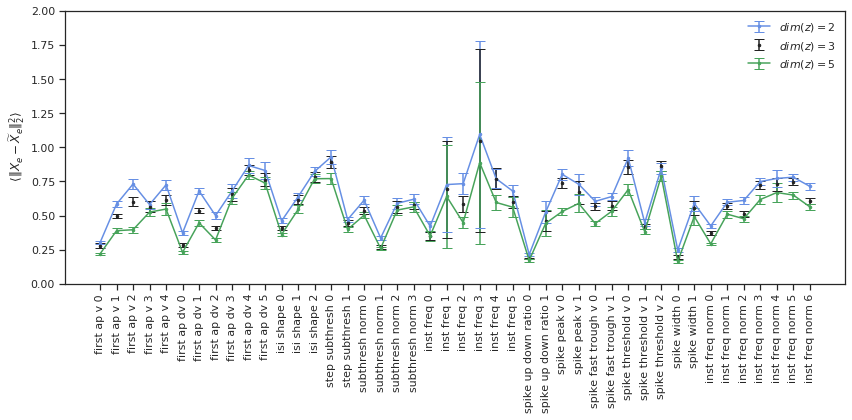

In [63]:
xx = np.arange(0,X.shape[1],1)

#Within modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)/np.sqrt(Y.shape[0])

yy3=np.mean(Z,axis=0)
err3=np.std(Z,axis=0)/np.sqrt(Z.shape[0])

fig = plt.figure(figsize=(12,6))
sns.set()
sns.set_style('ticks',{'axes.grid' : False})

plt.errorbar(x=xx,y=yy,yerr=err,capsize=5,c=cols[0],ls='-',marker='.',ms=5,label=r'$dim(z)=2$')
plt.errorbar(x=xx,y=yy2,yerr=err2,capsize=5,c=cols[1],ls='',marker='.',ms=5,label=r'$dim(z)=3$')
plt.errorbar(x=xx,y=yy3,yerr=err3,capsize=5,c=cols[2],ls='-',marker='.',ms=5,label=r'$dim(z)=5$')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_list)))
ax.set_xticklabels(E_features_list,rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} -  \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.0)
plt.legend(edgecolor='None')
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_dim_sweep_v2_ft.png',dpi=300)

**Representations**

In [1]:
import os
import fnmatch
import pprint

import numpy as np
import scipy.io as sio
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import HTML

def scatter3(X,col,xlims=(3,3),ylims=(3,3),zlims=(3,3)):
    sns.set_style("whitegrid")
    plt.ion()
    fig = plt.figure(figsize=(4,4))    
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X[:,0], X[:,1], X[:,2],s=1,alpha=1,c=col)

    ax.set_xticks([])
    ax.set_zticks([])
    ax.set_yticks([])
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_ylim(ylims[0],ylims[1])
    ax.set_zlim(zlims[0],zlims[1])

    plt.axis('on')
    ax.set_frame_on(False)
    plt.tight_layout()
    return ax,sc

In [16]:
dir_pth={}
raw_data_pth = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
dir_pth['result'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'

csTE='1-0'
aE = '1-0'
cv=1

#Full data matrices
O = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)

xlims=(-2.5,1.2)
ylims=(-1.1,3)
zlims=(-1.1,3)
padval=-210
fontsizeval=13

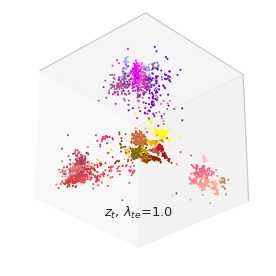

In [23]:
ax,sc = scatter3(D['zT'],O['cluster_color'],xlims,ylims,zlims)
ax.set_title(r'$z_t$, $\lambda_{te}$='+csTE.replace('-','.'),pad=padval,fontsize=fontsizeval)
ax.view_init(elev=-31.0, azim=-47)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return

#plt.savefig('/Users/fruity/Desktop/zT_alphaE_1_lambda_1.png',dpi=300)
#anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
#HTML(anim.to_html5_video())

In [ ]:
anim.save('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/representation_T_z_'+csTE+'.gif', dpi=160, writer='imagemagick')

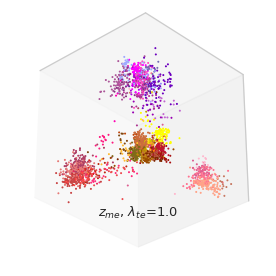

In [24]:
ax,sc = scatter3(D['zE'],O['cluster_color'],xlims,ylims,zlims)
ax.set_title(r'$z_{me}$, $\lambda_{te}$='+csTE.replace('-','.'),pad=padval,fontsize=fontsizeval)
ax.view_init(elev=-31.0, azim=-47)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return
#plt.savefig('/Users/fruity/Desktop/zE_alphaE_1_lambda_1.png',dpi=300)
# anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
# HTML(anim.to_html5_video())

In [ ]:
anim.save('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/representation_E_z_'+csTE+'.gif', dpi=160, writer='imagemagick')

**Effect of varying soma depth influence $\alpha_m$** 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
sns.set()

In [3]:
dir_pth = {}
dir_pth['result'] = '/home/rohan/Remote-AI/dat/result/TE_Patchseq_Bioarxiv/'
dir_pth['logs'] = dir_pth['result']+'logs/'
dir_pth['checkpoints'] =dir_pth['result']+'checkpoints/'

In [4]:
%matplotlib inline

In [5]:
this_epoch=499

csTE = 1.0
aE=1.0
aM_array = np.array([0.0,0.5,1.0,2.0,5.0,10.0,100.0])

T_recon_mean = np.empty((aM_array.size,))
E_recon_mean = np.empty((aM_array.size,))
M_recon_mean = np.empty((aM_array.size,))
TE_dist_mean = np.empty((aM_array.size,))

T_recon_se = np.empty((aM_array.size,))
E_recon_se = np.empty((aM_array.size,))
M_recon_se = np.empty((aM_array.size,))
TE_dist_se = np.empty((aM_array.size,))

csTE = str(csTE).replace('.','-')
aE = str(aE).replace('.','-')
for k,aM in enumerate(aM_array):
    aM = str(aM).replace('.','-')
    temp_T=[]
    temp_E=[]
    temp_M=[]
    temp_TE=[]
    for cv in range(9):
        file_id = 'v3_aT_1-0_aE_'+str(aE)+'_aM_'+str(aM)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft.csv'
        D = pd.read_csv(dir_pth['logs']+file_id)
        epoch_ind=D['train_epoch'].values==this_epoch
        temp_T.extend(D['val_mse_T'].values[epoch_ind])
        temp_E.extend(D['val_mse_E'].values[epoch_ind])
        temp_M.extend(D['val_mse_M'].values[epoch_ind])
        temp_TE.extend(D['val_mse_TE'].values[epoch_ind])
    T_recon_mean[k]=np.mean(temp_T)
    T_recon_se[k]=np.std(temp_T)/np.sqrt(len(temp_T))

    E_recon_mean[k]=np.mean(temp_E)
    E_recon_se[k]=np.std(temp_E)/np.sqrt(len(temp_E))

    M_recon_mean[k]=np.mean(temp_M)
    M_recon_se[k]=np.std(temp_M)/np.sqrt(len(temp_M))

    TE_dist_mean[k]=np.mean(temp_TE)
    TE_dist_se[k]=np.std(temp_TE)/np.sqrt(len(temp_TE))

In [8]:
M_recon_mean

array([0.5835443 , 0.12417102, 0.07048196, 0.04390196, 0.032107  ,
       0.02728079, 0.02291151])

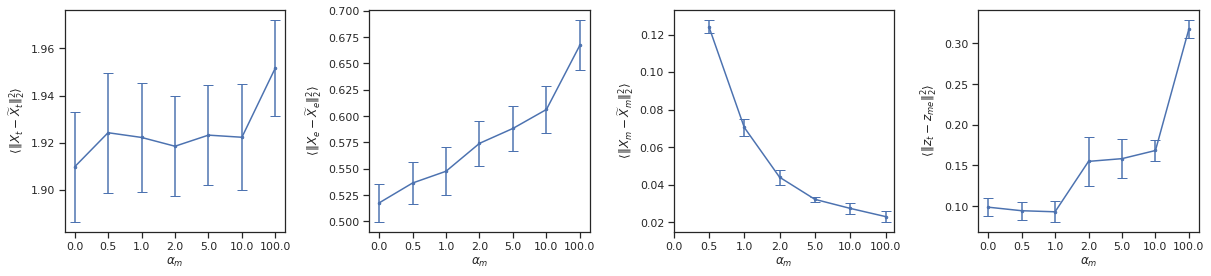

In [9]:
sns.set()
sns.set_style('ticks',{'axes.grid' : False})

plt.figure(figsize=(17,4))
plt.subplot(141)
plt.errorbar(np.arange(aM_array.size),T_recon_mean,T_recon_se,
             capsize=5,ls='-',marker='.',ms=5)
ax = plt.gca()
ax.set_xticks(np.arange(aM_array.size))
ax.set_xticklabels(aM_array)
ax.set_xlabel(r'$\alpha_m$')
ax.set_ylabel(r' $ \langle \Vert X_{t} -  \widetilde{X}_{t} \Vert_2^2 \rangle $')


plt.subplot(142)
plt.errorbar(np.arange(aM_array.size),E_recon_mean,E_recon_se,
             capsize=5,ls='-',marker='.',ms=5)
ax = plt.gca()
ax.set_xticks(np.arange(aM_array.size))
ax.set_xticklabels(aM_array)
ax.set_xlabel(r'$\alpha_m$')
ax.set_ylabel(r' $ \langle \Vert X_{e} -  \widetilde{X}_{e} \Vert_2^2 \rangle $')

plt.subplot(143)
plt.errorbar(np.arange(aM_array.size-1)+1,M_recon_mean[1:],M_recon_se[1:],
             capsize=5,ls='-',marker='.',ms=5)
ax = plt.gca()
ax.set_xticks(np.arange(aM_array.size))
ax.set_xticklabels(aM_array)
ax.set_xlabel(r'$\alpha_m$')
ax.set_ylabel(r' $ \langle \Vert X_{m} -  \widetilde{X}_{m} \Vert_2^2 \rangle $')

plt.subplot(144)
plt.errorbar(np.arange(aM_array.size),TE_dist_mean,TE_dist_se,
             capsize=5,ls='-',marker='.',ms=5)
ax = plt.gca()
ax.set_xticks(np.arange(aM_array.size))
ax.set_xticklabels(aM_array)
ax.set_xlabel(r'$\alpha_m$')
ax.set_ylabel(r' $ \langle \Vert z_{t} -  z_{me} \Vert_2^2 \rangle $')

plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/alpha_M_sweep.png',dpi=300)